##  Identify compounding drivers of river floods and associated flood complexity

The notebook illustrates the main procedures for identifying the compounding drivers of river floods and the associated flood complexity, as developed in the paper:

Jiang et al. (2024). [Compounding effects in flood drivers challenge estimates of extreme river floods](https://doi.org/10.1126/sciadv.adl4005). Science Advances, 10(13), eadl4005.

Date: 28.03.2024

Created by: Shijie Jiang

In [1]:
import os
import shap
import warnings
import lightgbm

import numpy as np
import scipy as sp
import pandas as pd
import proplot as pplt

from sklearn import model_selection
from tqdm import tqdm
from sklearn.metrics import r2_score

from libs import utils, plots

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

Rebuilding font cache. This usually happens after installing or updating proplot.


In [2]:
pplt.rc['font.family']      = 'DejaVu Sans'
pplt.rc['axes.grid']        = False
pplt.rc['figure.facecolor'] = 'None'

In [3]:
area              = 827.00                        # Catchment size in km2
lag_days_for_peak = int(5 + np.log(area / 2.59))  # Used for detecting identifiable peaks
lag_days          = 7                             # Used for model inputs

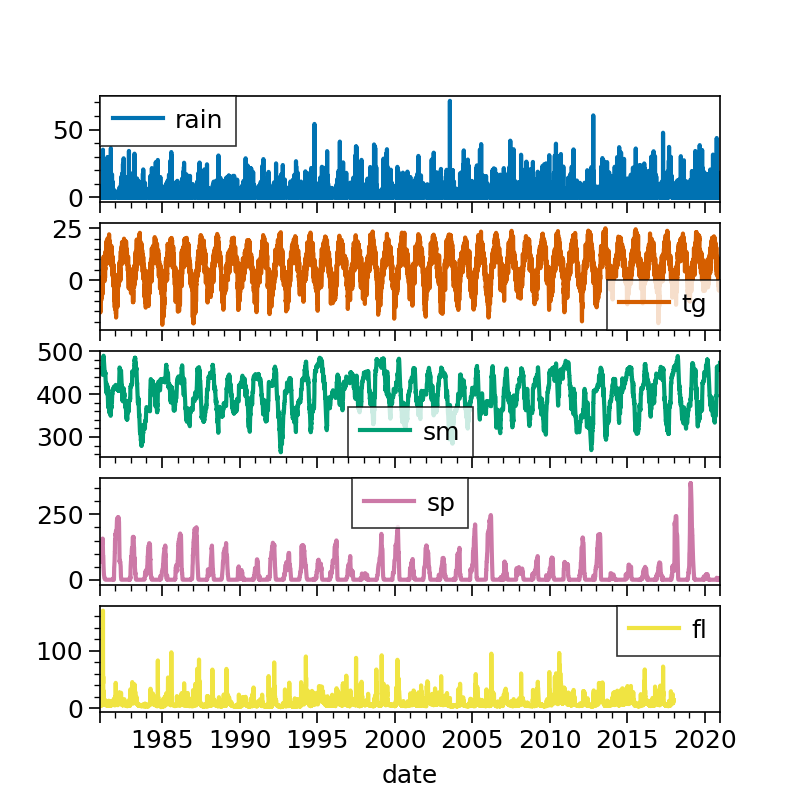

In [4]:
hydrodata    = utils.get_station_data('data/sample.csv')
hydrodata    = hydrodata[['rain', 'tg', 'sm', 'sp','fl']]

_ = hydrodata.plot(subplots=True)

In [5]:
all_dates_list, data_x_list, data_y_list = utils.get_wrapped_data(hydrodata, wrap_length=lag_days)

all_peak_dates = utils.identify_all_peaks(Q=hydrodata['fl'], 
                                          distance=lag_days_for_peak, 
                                          k=0.75, 
                                          valid_dates=all_dates_list, # We only consider the peaks that have valid inputs
                                         )

all_dates_list = pd.DatetimeIndex(all_dates_list)
all_peak_dates = pd.DatetimeIndex(all_peak_dates)

peak_series    = hydrodata.loc[all_peak_dates, 'fl']

A total of 487 peaks are identified, and 486 are valid.


In [6]:
am_peak_dates  = peak_series.groupby(peak_series.index.year).idxmax()
hydrodata_fl_enough_length = hydrodata['fl'].groupby(hydrodata.index.year).count() >= 200

am_peak_dates  = am_peak_dates[hydrodata_fl_enough_length]
am_series      = utils.get_return_periods(hydrodata.loc[am_peak_dates, 'fl'], plotting_position='weibull')

In [7]:
var_names = [f'rr_{i}' for i in range(lag_days-1, -1, -1)] + ['tg_avg'] + [f'sm_{lag_days}'] + [f'sp_{lag_days}']

In [8]:
pd_data = pd.DataFrame(data={'x_values': data_x_list,
                             'y_true': data_y_list,
                             'all_peak': False,
                             'am_peak': False},
                       index=pd.to_datetime(all_dates_list))
pd_data.loc[all_peak_dates, 'all_peak'] = True
pd_data.loc[am_peak_dates,  'am_peak'] = True
###################################################
pd_data_run           = pd.DataFrame(index=pd_data.index, data=np.vstack(pd_data['x_values']), columns=var_names)
pd_data_run['y_true'] = pd_data['y_true']
pd_data_run
###################################################
pd_data_eval          = pd_data.copy()

pd_all_peak_eval      = pd_data_eval[pd_data_eval['all_peak']]
pd_all_peak_eval      = pd_all_peak_eval.merge(am_series[['ranks', 
                                                          'exceedance probability', 
                                                          'non exceedance probability',
                                                          'return period']], 
                                               left_index=True, right_index=True, how='left')

# Model Training

In [9]:
r2_df      = pd.DataFrame(columns=['r2_train', 'r2_test'])
r2_df.index.name = 'n'

model_list = []

kf = model_selection.RepeatedKFold(n_splits=5, n_repeats=100, random_state=42)
nn  = 0

pd_is_tested_nn_list = []
#########################################
monotone_constraints = [1 for i in range(lag_days)] + [0, 1, 1]

interactions_all = [[i, j] for i in [k for k in range(lag_days+3)] for j in [k for k in range(lag_days+3)] if i <= j]
interactions_rm1 = [[i, j] for i in [k for k in range(lag_days)] for j in [k for k in range(lag_days, lag_days+1)] if i < j]
interaction_constraints = [s for s in interactions_all if s not in interactions_rm1]
#########################################
for train_index, test_index in tqdm(kf.split(np.arange(len(all_peak_dates)))):
    train_dates = all_peak_dates[train_index]
    test_dates  = all_peak_dates[test_index]
    #########################################
    train_x     = pd_data_run.loc[train_dates, pd_data_run.columns!='y_true'].values
    train_y     = pd_data_run.loc[train_dates, 'y_true'].values
    test_x      = pd_data_run.loc[test_dates, pd_data_run.columns!='y_true'].values
    test_y      = pd_data_run.loc[test_dates, 'y_true'].values
    ########## 
    pd_is_tested_nn = pd.DataFrame(index=all_peak_dates, columns=[f'is_test_{nn:03d}'], data=False)
    pd_is_tested_nn.loc[test_dates] = True
    pd_is_tested_nn_list.append(pd_is_tested_nn)
    #########################################
    candidate_params = {
        'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],
        'n_estimators': [50, 100, 150, 200],
        'subsample': [0.3, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.5, 0.7],
        'max_bin': [8, 16, 24, 32, 64],
        'monotone_constraints': [monotone_constraints],
        'interaction_constraints': [interaction_constraints],
        'min_child_samples': [3, 5, 7],
    }
    grid = model_selection.RandomizedSearchCV(lightgbm.LGBMRegressor(), 
                                              candidate_params, 
                                              n_iter=64, 
                                              scoring='r2', 
                                              cv=5, 
                                              n_jobs=-1, 
                                              random_state=42 * nn)
    grid.fit(train_x, train_y)
    
    clf_model   = lightgbm.LGBMRegressor(**grid.best_params_)
    clf_model.fit(train_x, train_y, 
                  callbacks=[lightgbm.early_stopping(stopping_rounds=8, verbose=0)],
                  eval_set=[(train_x, train_y)], verbose=0
                 )
    model_list.append(clf_model)
    #########################################
    train_pred = clf_model.predict(train_x)
    test_pred  = clf_model.predict(test_x)
    train_r2   = r2_score(y_true=train_y, y_pred=train_pred)
    test_r2    = r2_score(y_true=test_y,  y_pred=test_pred)
    
    r2_df      = r2_df.append({'r2_train': train_r2, 'r2_test': test_r2}, ignore_index=True)
    #########################################
    nn = nn + 1
    
pd_is_tested = pd.concat(pd_is_tested_nn_list, axis=1)

print(f"mean_r2_train: {np.mean(r2_df['r2_train']):.3f}   mean_r2_test: {np.mean(r2_df['r2_test']):.3f}")

500it [15:41,  1.88s/it]

mean_r2_train: 0.782   mean_r2_test: 0.455


# Interpret

In [10]:
intetpret_model_list = model_list.copy()

In [12]:
pd_all_peak_eval_list = []

for n, intetpret_model in tqdm(enumerate(intetpret_model_list)):
    pd_data_expalin = pd_data_eval[pd_data_eval['all_peak']]
    pd_data_expalin = pd_data_expalin.sort_index()
    pd_data_expalin = pd.DataFrame(index=pd_data_expalin.index, 
                                   data=np.vstack(pd_data_expalin['x_values']), 
                                   columns=var_names)
    ########################################################
    pd_all_peak_eval_n = pd.DataFrame(index=pd_data_expalin.index)
    ########################################################
    peak_x = pd_data_expalin.values
    peak_y = pd_data_eval[pd_data_eval['all_peak']].sort_index()['y_true'].values
    peak_pred = intetpret_model.predict(peak_x)
    ############################
    explainer_int           = shap.TreeExplainer(intetpret_model, 
                                                 feature_names=var_names)
    
    shap_interaction_values = explainer_int.shap_interaction_values(X=peak_x, y=peak_y)
    shap_interaction_values = shap_interaction_values.reshape([-1, len(var_names)*len(var_names)])
    ########################################################
    pd_all_peak_eval_n[f'y_pred_{n:03d}'] = peak_pred
    pd_all_peak_eval_n[f'y_bar_{n:03d}']  = explainer_int.expected_value
    pd_all_peak_eval_n[f'ex_int_{n:03d}'] = shap_interaction_values.tolist()
    pd_all_peak_eval_list.append(pd_all_peak_eval_n)

500it [01:54,  4.37it/s]


In [13]:
pd_all_peak_eval = pd_all_peak_eval.merge(pd.concat(pd_all_peak_eval_list, axis=1), left_index=True, right_index=True)
pd_all_peak_eval.index.name = 'date'

# Analysis (compounding drivers)

In [14]:
compounding_drivers_results = utils.analyze_compounding_driver(pd_all_peak_eval,
                                                               pd_is_tested,
                                                               var_names,
                                                               n_splits=5,
                                                               n_repeats=100, 
                                                               quantile_v=0.8 # using the 80th percentile
                                                              )

pd_all_peak_ex_all, pd_all_peak_ex_all_imp, all_thresholds = compounding_drivers_results

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.97it/s]


In [15]:
pd_am_peak_ex_all_imp = pd_all_peak_ex_all_imp.loc[am_peak_dates]
pd_am_peak_ex_all_imp

,rr_imp,tg_imp,sm_imp,sp_imp,rep
date,,,,,
1981-03-12,True,True,True,True,0
1981-03-12,True,True,True,True,1
1981-03-12,True,False,True,True,2
1981-03-12,True,False,True,True,3
1981-03-12,True,False,True,True,4
...,...,...,...,...,...
2017-04-29,True,False,True,False,95
2017-04-29,True,False,True,False,96
2017-04-29,True,False,True,False,97


In [16]:
pd_all_peak_all_analysis = pd.DataFrame(index=pd.to_datetime(pd_all_peak_eval.index))

pd_all_peak_all_analysis['rr_value'] = pd_all_peak_eval['x_values'].apply(lambda x: np.mean(x[0:lag_days]))
pd_all_peak_all_analysis['tg_value'] = pd_all_peak_eval['x_values'].apply(lambda x: np.mean(x[lag_days+0:lag_days+1]))
pd_all_peak_all_analysis['sm_value'] = pd_all_peak_eval['x_values'].apply(lambda x: np.mean(x[lag_days+1:lag_days+2]))
pd_all_peak_all_analysis['sp_value'] = pd_all_peak_eval['x_values'].apply(lambda x: np.mean(x[lag_days+2:lag_days+3]))

pd_all_peak_all_analysis = pd_all_peak_all_analysis.merge(pd_all_peak_eval[['y_true', 
                                                                            'all_peak', 
                                                                            'exceedance probability', 
                                                                            'return period']], 
                                                          left_index=True, right_index=True)

pd_all_peak_all_analysis = pd_all_peak_all_analysis.merge(pd_all_peak_ex_all.groupby(pd_all_peak_ex_all.index)['rr_shap','tg_shap','sm_shap','sp_shap'].quantile(0.50).add_suffix('_q50'),
                                                          left_index=True, right_index=True)

pd_all_peak_all_analysis = pd_all_peak_all_analysis.merge(pd_all_peak_ex_all.groupby(pd_all_peak_ex_all.index)['rr_shap','tg_shap','sm_shap','sp_shap'].quantile(0.90).add_suffix('_q90'),
                                                          left_index=True, right_index=True)

pd_all_peak_all_analysis = pd_all_peak_all_analysis.merge(pd_all_peak_ex_all.groupby(pd_all_peak_ex_all.index)['rr_shap','tg_shap','sm_shap','sp_shap'].quantile(0.10).add_suffix('_q10'),
                                                          left_index=True, right_index=True)


for var in ['rr', 'tg', 'sm', 'sp']:
    pd_all_peak_all_analysis[f'{var}_shap_q90_diff'] = pd_all_peak_all_analysis[f'{var}_shap_q90'] - pd_all_peak_all_analysis[f'{var}_shap_q50']
    pd_all_peak_all_analysis[f'{var}_shap_q10_diff'] = pd_all_peak_all_analysis[f'{var}_shap_q50'] - pd_all_peak_all_analysis[f'{var}_shap_q10']

pd_am_peak_all_analysis = pd_all_peak_all_analysis.loc[am_peak_dates]
pd_am_peak_all_analysis = pd_am_peak_all_analysis.merge(pd_am_peak_ex_all_imp.groupby(pd_am_peak_ex_all_imp.index).sum()[['rr_imp','tg_imp','sm_imp','sp_imp']].add_suffix('_sum'),
                                                        left_index=True, right_index=True)

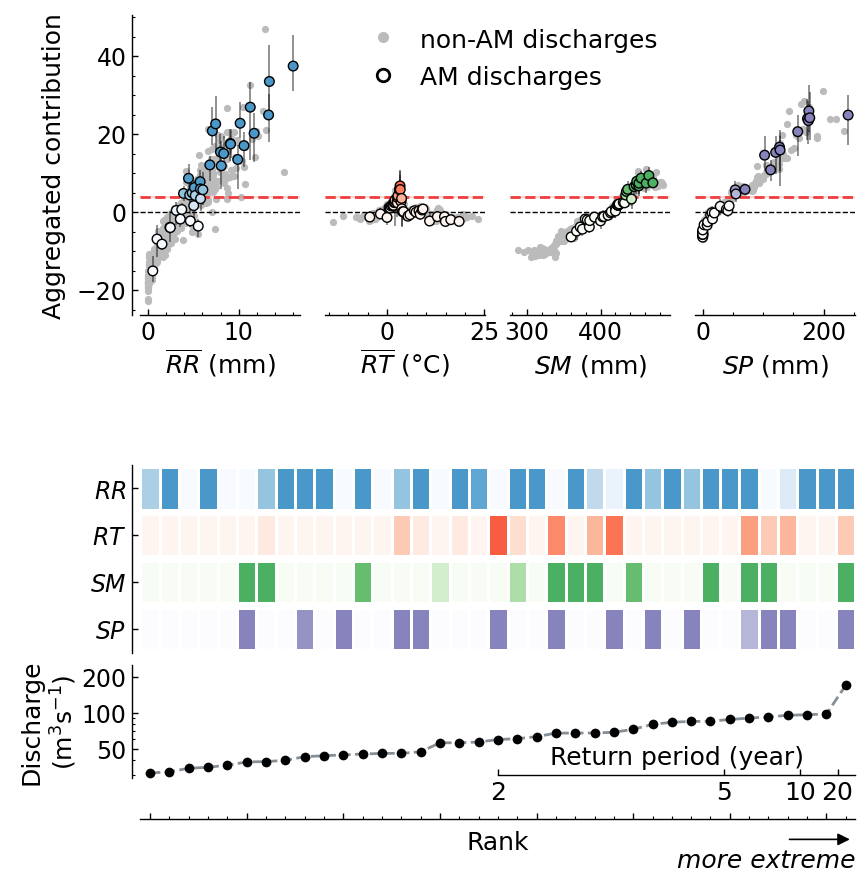

In [17]:
plots.plot_compounding_driver(pd_all_peak_all_analysis, pd_am_peak_all_analysis, all_thresholds, n_repeats=100)

# Analysis (flood complexity)

In [18]:
flood_complexity_results = utils.analyze_flood_complexity(pd_all_peak_eval,
                                                          pd_is_tested,
                                                          var_names,
                                                          n_splits=5, 
                                                          n_repeats=100, 
                                                          quantile_v=0.8 # using the 80th percentile
                                                         )
    
pd_all_peak_ex_ori, pd_all_peak_ex_ori_imp, ori_thresholds = flood_complexity_results

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.53it/s]


In [19]:
pd_am_peak_ex_ori_imp = pd_all_peak_ex_ori_imp.loc[am_peak_dates]

In [20]:
pd_am_peak_ex_ori_imp['num_interaction']  = pd_am_peak_ex_ori_imp[pd_am_peak_ex_ori_imp.columns[pd_am_peak_ex_ori_imp.columns.str.endswith('_imp')]].astype(int).sum(1)
pd_am_peak_ex_ori_imp['prop_interaction'] = pd_am_peak_ex_ori_imp['num_interaction'] / 48 * 100

com_slope_s_complex = pd_am_peak_ex_ori_imp.groupby('rep').apply(lambda x: sp.stats.linregress(100 - x['exceedance probability']*100, x['prop_interaction'], alternative='greater')[0])
com_slope_i_complex = pd_am_peak_ex_ori_imp.groupby('rep').apply(lambda x: sp.stats.linregress(100 - x['exceedance probability']*100, x['prop_interaction'], alternative='greater')[1])
com_slope_p_complex = pd_am_peak_ex_ori_imp.groupby('rep').apply(lambda x: sp.stats.linregress(100 - x['exceedance probability']*100, x['prop_interaction'], alternative='greater')[3]) 

statistics_agg_complex = pd.DataFrame({'com_slope_s': com_slope_s_complex, 
                                       'com_slope_i': com_slope_i_complex, 
                                       'com_slope_p': com_slope_p_complex})

In [21]:
pd_am_peak_eval_interaction = pd_all_peak_eval[['y_true','exceedance probability','return period']].loc[am_peak_dates].copy()

pd_am_peak_eval_interaction['num_imp_q50'] =  pd_am_peak_ex_ori_imp.groupby(pd_am_peak_ex_ori_imp.index)['prop_interaction'].quantile(0.50)
pd_am_peak_eval_interaction['num_imp_q10'] =  pd_am_peak_ex_ori_imp.groupby(pd_am_peak_ex_ori_imp.index)['prop_interaction'].quantile(0.25)
pd_am_peak_eval_interaction['num_imp_q90'] =  pd_am_peak_ex_ori_imp.groupby(pd_am_peak_ex_ori_imp.index)['prop_interaction'].quantile(0.75)

pd_am_peak_eval_interaction['non exceedance probability'] = (1 - pd_am_peak_eval_interaction['exceedance probability']) * 100

pd_am_peak_eval_interaction['num_imp_q90_diff'] =  pd_am_peak_eval_interaction['num_imp_q90'] - pd_am_peak_eval_interaction['num_imp_q50'] 
pd_am_peak_eval_interaction['num_imp_q10_diff'] =  pd_am_peak_eval_interaction['num_imp_q50'] - pd_am_peak_eval_interaction['num_imp_q10'] 

pd_am_peak_eval_interaction = pd_am_peak_eval_interaction.sort_values('y_true')

com_linear_inter = statistics_agg_complex['com_slope_i'].values
com_linear_slope = statistics_agg_complex['com_slope_s'].values
com_linear_pvalu = statistics_agg_complex['com_slope_p'].values

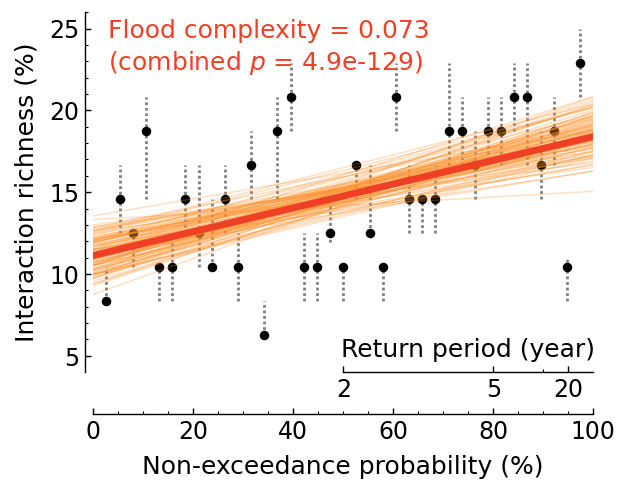

In [22]:
plots.plot_flood_complexity(pd_am_peak_eval_interaction, com_linear_inter, com_linear_slope, com_linear_pvalu, n_repeats=100)